## Importation


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import shutil
import os
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU)

##Data Load

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d huanghanchina/pascal-voc-2012

100% 3.62G/3.63G [00:43<00:00, 105MB/s]
100% 3.63G/3.63G [00:43<00:00, 89.0MB/s]


In [ ]:
!unzip "/content/pascal-voc-2012.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001829.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001874.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001876.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001882.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001885.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001895.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001896.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001926.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001966.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001971.png  
  inflating: /content/dataset/voc2012/VOC2012/SegmentationClass/2008_001992.png  
  inflating: /content/dataset/voc2012/VOC2012/S

In [ ]:
train_images='/content/dataset/VOC2012/JPEGImages/'
train_maps='/content/dataset/VOC2012/Annotations/'

val_images='/content/dataset/VOC2012/ValJPEGImages/'
val_maps='/content/dataset/VOC2012/ValAnnotations/'

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

In [ ]:
B=2
N_CLASSES=len(classes)
H,W=224,224
SPLIT_SIZE=H//32
N_EPOCHS=100
BATCH_SIZE=64

In [ ]:
val_list=['2007_000027.jpg','2007_000032.jpg','2007_000033.jpg','2007_000039.jpg','2007_000042.jpg','2007_000061.jpg',
          '2007_000063.jpg','2007_000068.jpg','2007_000121.jpg','2007_000123.jpg','2007_000129.jpg','2007_000170.jpg',
          '2007_000175.jpg','2007_000187.jpg','2007_000241.jpg','2007_000243.jpg','2007_000250.jpg','2007_000256.jpg',
          '2007_000272.jpg','2007_000323.jpg','2007_000332.jpg','2007_000333.jpg','2007_000346.jpg','2007_000363.jpg',
          '2007_000364.jpg','2007_000392.jpg','2007_000423.jpg','2007_000452.jpg','2007_000464.jpg','2007_000480.jpg',
          '2007_000491.jpg','2007_000504.jpg','2007_000515.jpg','2007_000528.jpg','2007_000529.jpg','2007_000549.jpg',
          '2007_000559.jpg','2007_000572.jpg','2007_000584.jpg','2007_000629.jpg','2007_000636.jpg','2007_000645.jpg',
          '2007_000648.jpg','2007_000661.jpg','2007_000663.jpg','2007_000664.jpg','2007_000676.jpg','2007_000713.jpg',
          '2007_000720.jpg','2007_000727.jpg','2007_000733.jpg','2007_000738.jpg','2007_000762.jpg','2007_000768.jpg',
          '2007_000783.jpg','2007_000793.jpg','2007_000799.jpg','2007_000804.jpg','2007_000807.jpg','2007_000822.jpg',
          '2007_001299.jpg','2007_001311.jpg','2007_001321.jpg','2007_001340.jpg']

In [ ]:
!mkdir /content/dataset/VOC2012/ValJPEGImages/
!mkdir /content/dataset/VOC2012/ValAnnotations/

mkdir: cannot create directory ‘/content/dataset/VOC2012/ValJPEGImages/’: File exists
mkdir: cannot create directory ‘/content/dataset/VOC2012/ValAnnotations/’: File exists


In [ ]:
for name in val_list:
  shutil.move(train_maps+name[:-3]+"xml",val_maps+name[:-3]+"xml")

In [ ]:
for name in val_list:
  shutil.move(train_images+name,val_images+name)

##Preprocess Data

In [ ]:
def preprocess_xml(filename):
  tree = ET.parse(filename)
  root = tree.getroot()
  size_tree = root.find('size')
  height = float(size_tree.find('height').text)
  width = float(size_tree.find('width').text)
  bounding_boxes=[]
  for object_tree in root.findall('object'):
    for bounding_box in object_tree.iter('bndbox'):
      xmin = (float(bounding_box.find('xmin').text))
      ymin = (float(bounding_box.find('ymin').text))
      xmax = (float(bounding_box.find('xmax').text))
      ymax = (float(bounding_box.find('ymax').text))
      break
    class_name = object_tree.find('name').text
    class_dict={classes[i]:i for i in range(len(classes))}
    bounding_box = [
        (xmin+xmax)/(2*width),(ymin+ymax)/(2*height),(xmax-xmin)/width,
        (ymax-ymin)/height,class_dict[class_name]]
    bounding_boxes.append(bounding_box)
  return tf.convert_to_tensor(bounding_boxes)

In [ ]:
def generate_output(bounding_boxes):
  output_label=np.zeros((SPLIT_SIZE,SPLIT_SIZE,N_CLASSES+5))
  for b in range(len(bounding_boxes)):
    grid_x=bounding_boxes[...,b,0]*SPLIT_SIZE
    grid_y=bounding_boxes[...,b,1]*SPLIT_SIZE
    i=int(grid_x)
    j=int(grid_y)

    output_label[i,j,0:5]=[1.,grid_x%1,grid_y%1,bounding_boxes[...,b,2],bounding_boxes[...,b,3]]
    output_label[i,j,5+int(bounding_boxes[...,b,4])]=1.

  return tf.convert_to_tensor(output_label,tf.float32)

In [ ]:
generate_output(preprocess_xml(val_maps+"2007_000032.xml"),)[3][3]


<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([1.        , 0.35299993, 0.25088978, 0.542     , 0.37366548,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>

In [ ]:
im_paths=[]
xml_paths=[]

val_im_paths=[]
val_xml_paths=[]


for i in os.listdir(train_maps):

  im_paths.append(train_images+i[:-3]+'jpg')
  xml_paths.append(train_maps+i)

for i in os.listdir(val_maps):

  val_im_paths.append(val_images+i[:-3]+'jpg')
  val_xml_paths.append(val_maps+i)

print(len(im_paths),len(xml_paths))
print(len(val_im_paths),len(val_xml_paths))
print(os.listdir(train_maps)[0])

17061 17061
64 64
2010_000483.xml


In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((im_paths,xml_paths))
val_dataset=tf.data.Dataset.from_tensor_slices((val_im_paths,val_xml_paths))

In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValJPEGImages/2007_000762.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValAnnotations/2007_000762.xml'>)


In [ ]:
def get_imbboxes(im_path,xml_path):
  img=tf.io.decode_jpeg(tf.io.read_file(im_path))
  img=tf.cast(tf.image.resize(img, [H,W]),dtype=tf.float32)

  bboxes=tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)
  return img,bboxes

In [ ]:
train_dataset=train_dataset.map(get_imbboxes)
val_dataset=val_dataset.map(get_imbboxes)

##DATA AUGMENTATION


In [ ]:
transforms = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(
         width=np.random.randint(int(0.9*W),W),
         height=np.random.randint(int(0.9*H),H), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5,),
    A.Resize(H,W),

], bbox_params=A.BboxParams(format='yolo', ))

In [ ]:
def aug_albument(image,bboxes):
  augmented=transforms(image=image,bboxes=bboxes)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["bboxes"],dtype=tf.float32)]

In [ ]:
def process_data(image,bboxes):
    aug= tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=(tf.float32,tf.float32))
    return aug[0],aug[1]

In [ ]:
train_dataset=train_dataset.map(process_data)

In [ ]:
def preprocess_augment(img,y):
  img = tf.image.random_brightness(img, max_delta=50.)
  img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  img = tf.clip_by_value(img, 0, 255)
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [ ]:
def preprocess(img,y):
  img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)

  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  return img,labels

In [ ]:
train_dataset=train_dataset.map(preprocess_augment)
val_dataset=val_dataset.map(preprocess)

In [ ]:
train_dataset=(
  train_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset=(
  val_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

##Modeling

In [ ]:
base_model=tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
base_model.trainable=False

In [ ]:
NUM_FILTERS=512
OUTPUT_DIM=N_CLASSES+5*B

In [ ]:
model=tf.keras.Sequential([
  base_model,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),

  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Dropout(0.5),

  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,activation='sigmoid'),

  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 512)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_5 (Bat  (None, 7, 7, 512)        

##Training

In [ ]:
def compute_iou(boxes1, boxes2):
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

In [ ]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

In [ ]:
def yolo_loss(y_true, y_pred):
  target = y_true[...,0]

  ###################### OBject Loss
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))

  rescaler = tf.where(target[:]==1)*SPLIT_SIZE
  upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)

  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)

  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2

  mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)

  y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))

  obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))

  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))

  ####################### For No object
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss = no_object_loss_1+no_object_loss_2

  ######################## For OBject class loss
  y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))
  class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

  class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                ,tf.cast(class_extract,dtype=tf.float32))

  ######################### For object bounding box loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
  centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))

  centre_loss = difference(centre_pred,centre_target)

  size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss+size_loss

  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32)
  return loss

In [ ]:
checkpoint_filepath='/content/drive/MyDrive/Bang/yolo_efficientnet_b1_new.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 40:
    return 1e-3
  elif epoch>=40 and epoch<80:
    return 5e-4
  else:
    return 1e-4

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.compile(
  loss=yolo_loss,
  optimizer=Adam(1e-3),
)

In [ ]:
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=20,
  callbacks = [lr_callback,callback]
)

Epoch 1/20
267/267 [==============================] - 263s 786ms/step - loss: 396.4882 - val_loss: 393.8679 - lr: 0.0010
Epoch 2/20
267/267 [==============================] - 186s 697ms/step - loss: 308.1459 - val_loss: 351.8231 - lr: 0.0010
Epoch 3/20
267/267 [==============================] - 184s 688ms/step - loss: 288.2977 - val_loss: 336.9797 - lr: 0.0010
Epoch 4/20
267/267 [==============================] - 187s 702ms/step - loss: 273.9543 - val_loss: 320.1101 - lr: 0.0010
Epoch 5/20
267/267 [==============================] - 184s 690ms/step - loss: 262.6118 - val_loss: 308.2000 - lr: 0.0010
Epoch 6/20
267/267 [==============================] - 185s 694ms/step - loss: 253.1096 - val_loss: 291.2716 - lr: 0.0010
Epoch 7/20
267/267 [==============================] - 186s 695ms/step - loss: 244.5688 - val_loss: 292.2473 - lr: 0.0010
Epoch 8/20
267/267 [==============================] - 184s 690ms/step - loss: 237.3355 - val_loss: 282.3671 - lr: 0.0010
Epoch 9/20
267/267 [============

##Evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
!mkdir outputs

In [ ]:
test_path_coco='/content/test/'

In [ ]:
def model_test(filename):
  try:
    test_path=test_path_coco+filename

    print(test_path)

    img=cv2.resize(cv2.imread(test_path),(H,W))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])

    output=model.predict(np.expand_dims(image, axis = 0))

    THRESH=.25

    object_positions=tf.concat(
        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
    print(object_positions)
    selected_output=tf.gather_nd(output,object_positions)
    print(selected_output)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
      for j in range(2):
        if selected_output[i][j*5]>THRESH:
          output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H
          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])
    print(final_scores)
    print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)

    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]

    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
        score_threshold=float('-inf')
    )
    print(nms_output)

    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    cv2.imwrite('/content/outputs/'+filename[:-4]+'_det'+'.jpg',cv2.resize(img,(384,384)))
  except:
    print("NO object found !!!")

In [ ]:
for filename in os.listdir(test_path_coco):
  model_test(filename)

/content/test/000000000247.jpg
1/1 [==============================] - 3s 3s/step
tf.Tensor(
[[0 3 3]
 [0 3 3]], shape=(2, 3), dtype=int64)
tf.Tensor(
[[3.4747449e-01 4.4035724e-01 4.4964617e-01 3.8689658e-01 2.9246616e-01
  9.5538312e-01 3.9110157e-01 4.6229896e-01 9.3431032e-01 7.5780630e-01
  9.0409595e-01 4.0310742e-03 2.6901375e-04 2.9149640e-03 3.0689253e-04
  1.0326405e-01 3.0505224e-03 6.7326437e-05 1.3605729e-03 3.3281234e-04
  3.3350059e-04 2.5988589e-05 2.8712689e-03 6.1999289e-03 3.0643158e-02
  9.3035639e-04 2.1414615e-03 5.5215484e-03 8.5223876e-03 5.0786597e-04]
 [3.4747449e-01 4.4035724e-01 4.4964617e-01 3.8689658e-01 2.9246616e-01
  9.5538312e-01 3.9110157e-01 4.6229896e-01 9.3431032e-01 7.5780630e-01
  9.0409595e-01 4.0310742e-03 2.6901375e-04 2.9149640e-03 3.0689253e-04
  1.0326405e-01 3.0505224e-03 6.7326437e-05 1.3605729e-03 3.3281234e-04
  3.3350059e-04 2.5988589e-05 2.8712689e-03 6.1999289e-03 3.0643158e-02
  9.3035639e-04 2.1414615e-03 5.5215484e-03 8.5223876e-03

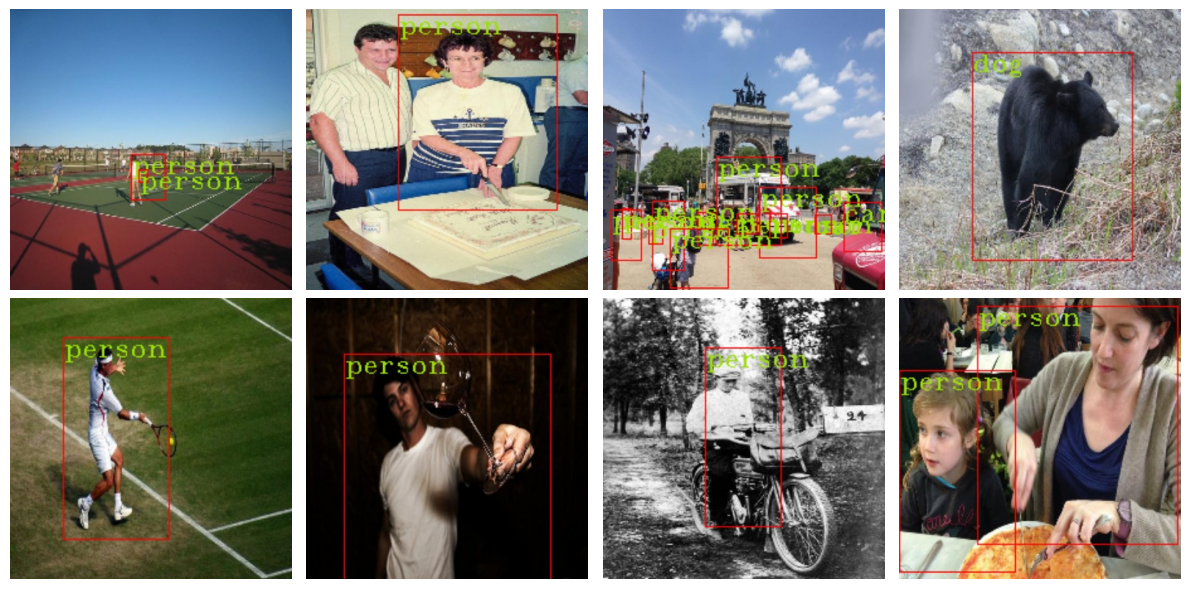

In [ ]:
from matplotlib.image import imread

folder_path = "/content/outputs"

files = os.listdir(folder_path)

image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg'))]

num_images_to_plot = min(8, len(image_files))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

axes = axes.flatten()

for i in range(num_images_to_plot):
    image_path = os.path.join(folder_path, image_files[i])
    image = imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()

plt.show()
